In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy.stats import norm
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Load the data
data = pd.read_csv('D:\College\Semester 6 (Magang)\Model\Anomaly Detection\clean_data.csv')

In [ ]:
# Parsing timestamp
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [ ]:
# List of feature columns
feature_columns = ['Ngp', 'Npt', 'HPC_ASV_Command', 'HPC_ASV_Position', 'HPC_Surge_Margin',
                   'HPC_ASC_Flow_DP', 'HPC_Suction_Press', 'HPC_Discharge_Press']

In [ ]:
data[feature_columns] = data[feature_columns].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Clean the data
data_cleaned = data.replace('Bad', np.nan).dropna()

In [ ]:
# Ensure Timestamp is in datetime format
data_cleaned['Timestamp'] = pd.to_datetime(data_cleaned['Timestamp'], utc=True)

In [ ]:
# Extract time-related features
data_cleaned['Minute'] = data_cleaned['Timestamp'].dt.minute
data_cleaned['Hour'] = data_cleaned['Timestamp'].dt.hour
data_cleaned['Day'] = data_cleaned['Timestamp'].dt.day
data_cleaned['Month'] = data_cleaned['Timestamp'].dt.month
data_cleaned['Weekday'] = data_cleaned['Timestamp'].dt.weekday

# Cyclical encoding for 'Hour' and 'Minute'
data_cleaned['Hour_sin'] = np.sin(2 * np.pi * data_cleaned['Hour'] / 24)
data_cleaned['Hour_cos'] = np.cos(2 * np.pi * data_cleaned['Hour'] / 24)
data_cleaned['Minute_sin'] = np.sin(2 * np.pi * data_cleaned['Minute'] / 60)
data_cleaned['Minute_cos'] = np.cos(2 * np.pi * data_cleaned['Minute'] / 60)

# Group by (Day, Hour, Minute) and aggregate
data_aggregated = data_cleaned.groupby(['Day', 'Hour', 'Minute']).agg(['mean', 'std'])

# Rename the columns
data_aggregated.columns = [
    f'{agg_type.upper()}_{col}' for col, agg_type in data_aggregated.columns
]

# Reset index
data_aggregated = data_aggregated.reset_index()

In [ ]:
# 1. Drop STD columns
std_cols = [col for col in data_aggregated.columns if col.startswith('STD_')]
data_aggregated = data_aggregated.drop(std_cols, axis=1)

# 2. Create a Pipeline for Preprocessing (Without DBSCAN)
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# 3. Prepare Feature
features = data_aggregated.drop(['MEAN_Timestamp'], axis=1, errors='ignore')

# 4. Transform Features Using Preprocessing Pipeline
features_scaled = preprocessing_pipeline.fit_transform(features)

# 5. Tune DBSCAN to Achieve Target Anomaly Rate
target_anomaly_percentage = 2.02  # Target anomaly percentage
target_anomalies = int(len(features_scaled) * (target_anomaly_percentage / 100))  # Target number of anomalies

# Initial values for eps and min_samples
best_eps = 0.3  # Start with a reasonable value (e.g., from k-distance plot)
best_min_samples = 40  # Start with a reasonable value
best_anomalies = 0

# # Iterate to find the best parameters
# for eps in np.arange(0.3, 0.6, 0.05):  # Test eps values between 0.3 and 0.6
#     for min_samples in range(5, 30):  # Test min_samples values between 5 and 15
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
#         data_aggregated['anomaly'] = dbscan.fit_predict(features_scaled)

#         # Count anomalies (DBSCAN labels anomalies as -1)
#         num_anomalies = (data_aggregated['anomaly'] == -1).sum()
#         anomaly_percentage = (num_anomalies / len(features_scaled)) * 100

#         # Check if the current parameters are closer to the target
#         if abs(anomaly_percentage - target_anomaly_percentage) < abs(best_anomalies - target_anomaly_percentage):
#             best_eps = eps
#             best_min_samples = min_samples
#             best_anomalies = num_anomalies

#         print(f"eps={eps:.2f}, min_samples={min_samples}, anomalies={num_anomalies}, percentage={anomaly_percentage:.2f}%")

# Fit DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='euclidean', n_jobs=-1)
data_aggregated['anomaly'] = dbscan.fit_predict(features_scaled)

# Convert -1 (anomaly) to 1 and 0 (normal) to -1 for consistency
data_aggregated['anomaly'] = data_aggregated['anomaly'].map({-1: 1, 0: -1})

# 6. Calculate Distances (After DBSCAN)
nbrs = NearestNeighbors(n_neighbors=2).fit(features_scaled)
distances, indices = nbrs.kneighbors(features_scaled)
data_aggregated['distance_to_nearest'] = distances[:, 1]

# Print final results
num_anomalies = (data_aggregated['anomaly'] == 1).sum()
anomaly_percentage = (num_anomalies / len(features_scaled)) * 100
print(f"\nBest Parameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"Total samples: {len(features_scaled)}")
print(f"Number of anomalies: {num_anomalies}")
print(f"Anomaly percentage: {anomaly_percentage:.2f}%")


Best Parameters: eps=0.3, min_samples=40
Total samples: 24977
Number of anomalies: 516
Anomaly percentage: 2.07%


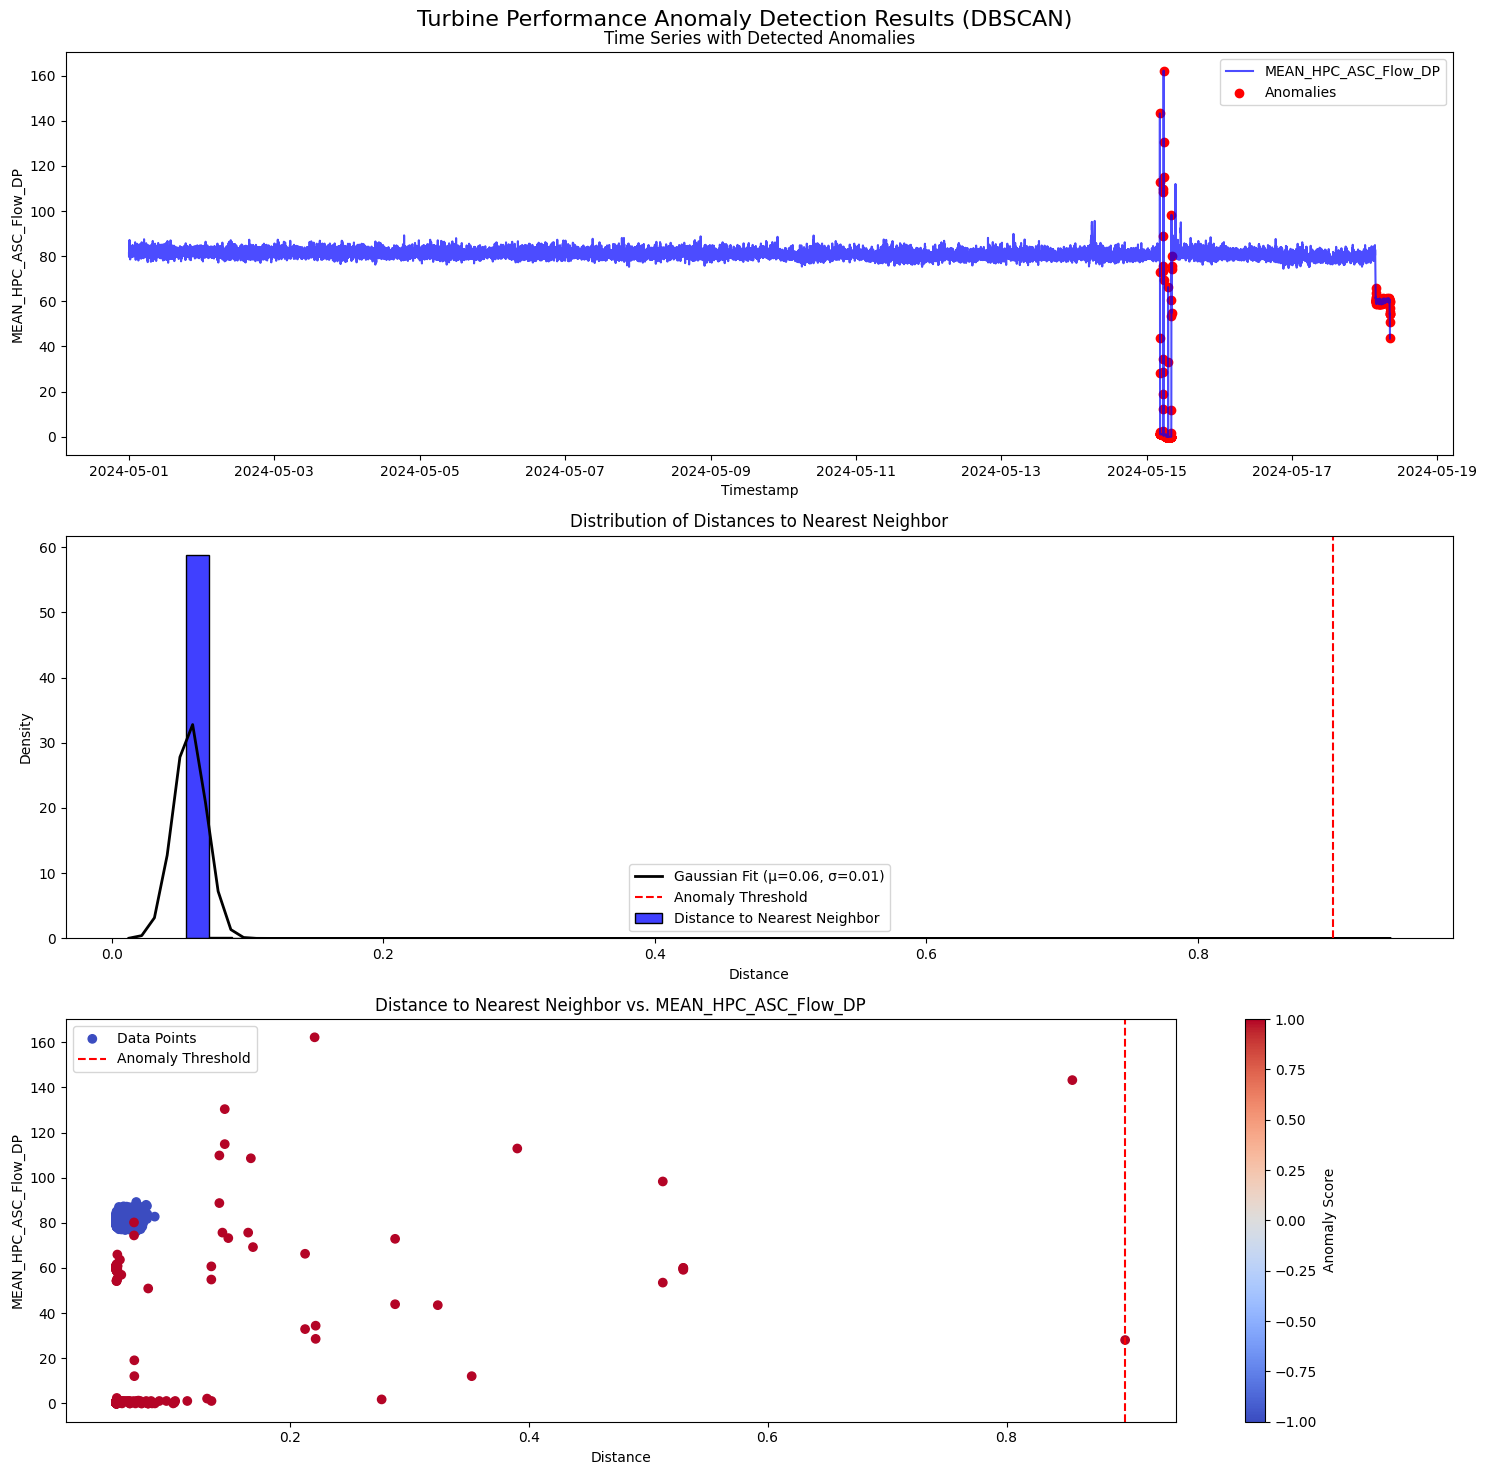

In [ ]:
def plot_anomalies(data):
    """Plots time series, anomaly scores (DBSCAN doesn't directly provide them), and anomaly scatter plot."""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    fig.suptitle('Turbine Performance Anomaly Detection Results (DBSCAN)', fontsize=16)

    # Plot 1: Time series with anomalies
    ax1.plot(data['MEAN_Timestamp'], data['MEAN_HPC_ASC_Flow_DP'], color='blue', label='MEAN_HPC_ASC_Flow_DP', alpha=0.7)
    anomalies = data[data['anomaly'] == 1]  # Anomalies are now 1
    ax1.scatter(anomalies['MEAN_Timestamp'], anomalies['MEAN_HPC_ASC_Flow_DP'], color='red', label='Anomalies')
    ax1.set_title('Time Series with Detected Anomalies')
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('MEAN_HPC_ASC_Flow_DP')
    ax1.legend()

    # Plot 2: Anomaly scores distribution (proxy using distance)
    nbrs = NearestNeighbors(n_neighbors=2).fit(features_scaled)
    distances, indices = nbrs.kneighbors(features_scaled)
    data_aggregated['distance_to_nearest'] = distances[:, 1]  # Distance to second nearest neighbor

    sns.histplot(data=data_aggregated, x='distance_to_nearest', bins=50, ax=ax2, kde=False, stat='density', color='blue', label='Distance to Nearest Neighbor')
    mu, std = data_aggregated['distance_to_nearest'].mean(), data_aggregated['distance_to_nearest'].std()
    xmin, xmax = ax2.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax2.plot(x, p, 'k', linewidth=2, label=f'Gaussian Fit (μ={mu:.2f}, σ={std:.2f})')
    threshold = anomalies['distance_to_nearest'].max() if not anomalies.empty else None
    if threshold is not None:
        ax2.axvline(x=threshold, color='red', linestyle='--', label='Anomaly Threshold')
    ax2.set_title('Distribution of Distances to Nearest Neighbor')
    ax2.set_xlabel('Distance')
    ax2.set_ylabel('Density')
    ax2.legend()

    # Plot 3: Scatter plot of Distance vs. MEAN_HPC_ASC_Flow_DP
    cmap = plt.get_cmap("coolwarm")
    sc = ax3.scatter(data_aggregated['distance_to_nearest'],
                     data_aggregated['MEAN_HPC_ASC_Flow_DP'],
                     c=data_aggregated['anomaly'], cmap=cmap, label='Data Points')

    ax3.set_title('Distance to Nearest Neighbor vs. MEAN_HPC_ASC_Flow_DP')
    ax3.set_xlabel('Distance')
    ax3.set_ylabel('MEAN_HPC_ASC_Flow_DP')

    if threshold is not None:
        ax3.axvline(x=threshold, color='red', linestyle='--', label='Anomaly Threshold')

    plt.colorbar(sc, ax=ax3, label='Anomaly Score')
    ax3.legend()

    plt.tight_layout()
    return fig

# Plot the results
fig = plot_anomalies(data_aggregated)
plt.show()